# 07. PyTorch Experiment Tracking

Machine learning is very experimental.

In order to figure out which experiment are worth purshing, that's where **experiment tracking** comes in, it helps you to figure out what doesn't work so you can figure out what **does** work.

In this notebook, we're going to see an example of programmatically tracking experiments.

Resources:
* [Book version of notebook](https://www.learnpytorch.io/07_pytorch_experiment_tracking/)
* [Ask a question](https://github.com/mrdbourke/pytorch-deep-learning/discussions)
* [Extra-curriculum](https://madewithml.com/courses/mlops/experiment-tracking/)

In [18]:
import torch
import torchvision

torch.__version__, torchvision.__version__

('1.13.0+cu117', '0.14.0+cu117')

In [19]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [20]:
# Set seeds
def set_seeds(seed: int = 42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [21]:
set_seeds()

## 1. Get data

Want to get pizza, steak, sushi images.

So we can run experiments building FoodVision Mini and see which model performs best.

In [22]:
import os
import zipfile
import requests
from pathlib import Path


# Example source: https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Download a zipped data set from source and unzip to destinaiton."""
    # Setup path to data folder
    data_path = Path('data/')
    image_path = data_path / destination

    # If image folder doesn't exist, creat it
    if image_path.is_dir():
        print(f'[INFO] {image_path} already exist, skipping download')
    else:
        print(f'[INFO] {image_path} does not exist, creating')
        image_path.mkdir(parents=True, exist_ok=True)

        # Download the target data
        target_file = Path(source).name
        with open(data_path / target_file, 'wb') as f:
            request = requests.get(source)
            print(f'[INFO] Downloading {target_file} from {source}')
            f.write(request.content)

        # Unzip target file
        with zipfile.ZipFile(data_path / target_file, 'r') as f:
            print(f'[INFO] Unzipping {target_file} data')
            f.extractall(image_path)

        # Remove zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

In [23]:
image_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',
                           destination='pizza_steak_sushi')

image_path

[INFO] data\pizza_steak_sushi already exist, skipping download


WindowsPath('data/pizza_steak_sushi')

## 2. Create DataSets and DataLoaders

### 2.1 Create DataLoaders with manual transforms

The goal with transforms is to ensure your custom data is transformed in a reproducible way as well as a way that will suit pretrained models.

In [24]:
# Setup a directories
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [25]:
# Setup ImageNet normalization levels
# See here: https://pytorch.org/vision/stable/models.html
from going_modular.data_setup import create_dataloaders
from torchvision import transforms


normalize = transforms.Normalize(mean=[.485, .456, .406],
                                 std=[.229, .224, .225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize
])
print(f'Manually created transforms: {manual_transforms}')

# Create DataLoaders

train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=32)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x1ddcbc24fa0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

The same principle applies for automatic transforms: we want our custom data in the same format as a pretrained model was trained on.

In [26]:
# Setup directories
import torchvision
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# Setup pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # "DEFAULT" = best available

# Get transforms from weights (these are the transforms used to train a particular or obtain a particular set of weights)
automatic_transforms = weights.transforms()
print(f'Automatically created transforms: {automatic_transforms}')

# Create DataLoaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=automatic_transforms, batch_size=32)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x1ddb15491e0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freeze the base layers and change the classifier head

In [27]:
# Download the pretrained weights for efficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [28]:
# Free all base layers by setting their required_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

In [29]:
# Chage the classifier hear
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

In [30]:
from torchinfo import summary


summary(model=model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

## 4. Train a single model and track results

In [31]:
# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=.001)

To track experiments, we're going to use [TensorBoard](https://www.tensorflow.org/tensorboard?hl=zh-tw)

And to interact with TensorBoard, we can use PyTorch's [SummaryWriter](https://pytorch.org/docs/stable/tensorboard.html)
  * Also see [here](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter)

In [32]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter


writer = SummaryWriter()
writer

In [33]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from going_modular.engine import train_step, test_step


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]} 
      For example if training for epochs=2: 
                   {train_loss: [2.0616, 1.0537],
                    train_acc: [0.3945, 0.3945],
                    test_loss: [1.2641, 1.5706],
                    test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        writer.add_scalars(main_tag='Loss',
                           tag_scalar_dict={'train_loss': train_loss,
                                            'test_loss': test_loss},
                           global_step=epoch)

        writer.add_scalars(main_tag='Accuracy',
                           tag_scalar_dict={'train_acc': train_acc,
                                            'test_acc': test_acc},
                           global_step=epoch)

        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the writer
    writer.close()
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [34]:
# Train model
# Note: not using engine.train(), since we updated the train() function above
set_seeds()

results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0744 | train_acc: 0.4219 | test_loss: 0.8657 | test_acc: 0.7737
Epoch: 2 | train_loss: 0.8918 | train_acc: 0.6641 | test_loss: 0.7681 | test_acc: 0.7945
Epoch: 3 | train_loss: 0.7432 | train_acc: 0.7500 | test_loss: 0.6500 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.6621 | train_acc: 0.8867 | test_loss: 0.6412 | test_acc: 0.8456
Epoch: 5 | train_loss: 0.6875 | train_acc: 0.7617 | test_loss: 0.6665 | test_acc: 0.8144


## 5. View our model's results with TensorBoard

There are a few ways to view TensorBoard results, see them [here](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#5-view-our-models-results-in-tensorboard)

In [42]:
# Let's view our experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 25292), started 19:23:28 ago. (Use '!kill 25292' to kill it.)

## 6. Create a function to prepare a `SummaryWriter()` instance

By default our `SummaryWriter()` saves to `log_dir`.

How about if we wanted to save different experiments to different folders?

In essence, one experiment = one folder

For example, we'd like to track:
* Experiment date/timestep
* Experiment name
* Model name
* Extra - is there anything else that should be tracked?

Let's create a function to create a `SummaryWriter()` instance to take all of these things into account.

So ideally we end up tracking experiments to a directory:

`run/YYYY-MM-DD/experiment_name/model_name/extra`

In [36]:
from torch.utils.tensorboard.writer import SummaryWriter


def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
    """Creat a torch.utils.tensorboard.writer.SummaryWriter() instance tracking to a specific directory."""
    from datetime import datetime
    import os

    # Get timestamp of current date in reverse order
    timestamp = datetime.now().strftime('%Y-%m-%d')

    if extra:
        # Create log directory path
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name)

    print(f'[INFO] Created SummaryWriter saving to {log_dir}')

    return SummaryWriter(log_dir=log_dir)

In [37]:
example_writer = create_writer(experiment_name='data_10_percent',
                               model_name='effnetb0',
                               extra='5_epochs')

example_writer

[INFO] Created SummaryWriter saving to runs\2023-07-18\data_10_percent\effnetb0\5_epochs


### 6.1 Update the `train()` function to include a `writer` parameter

In [38]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from going_modular.engine import train_step, test_step


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List[float]]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                    train_acc: [...],
                    test_loss: [...],
                    test_acc: [...]} 
      For example if training for epochs=2: 
                   {train_loss: [2.0616, 1.0537],
                    train_acc: [0.3945, 0.3945],
                    test_loss: [1.2641, 1.5706],
                    test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        if writer:
            writer.add_scalars(main_tag='Loss',
                            tag_scalar_dict={'train_loss': train_loss,
                                                'test_loss': test_loss},
                            global_step=epoch)

            writer.add_scalars(main_tag='Accuracy',
                            tag_scalar_dict={'train_acc': train_acc,
                                                'test_acc': test_acc},
                            global_step=epoch)

            writer.add_graph(model=model,
                            input_to_model=torch.randn(32, 3, 224, 224).to(device))

            # Close the writer
            writer.close()
            ### End new ###
        else:
            pass

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments

* Setup 2x modelling experiments with effnetb0, pizza, steak, sushi data and train one model for 5 epochs and another model for 10 epochs

### 7.1 What kind of experiments should you run?

The number of machine learning experiments you can run, is like the number of different models you can build... almost limitless.

However, you can't test everything...

So what should you test?
* Change the number of epochs
* Change the number of hidden layer/units
* Change the amount of data (right now we're using 10% of the Food101 dataset for pizza, steak, sushi)
* Change the learning rate
* Try different kinds of data augmentation
* Choose a different model architectures

This is why transfer learning is so powerful, because, it's a working model that you can apply to your own problem.

### 7.2 What experiments are we going to run?

We're going to turn three dials:
1. Model size - Effnetb0 vs EffnetB2 (in terms of number of parameters)
2. Dataset size - 10% of pizza, steak, sushi images vs 20% (generally more data = better results)
3. Training time - 5 epochs vs 10 epochs (generally longer training time = better results, up to a point)

To begin, we're still keeping things relatively small so that our experiments run quickly.

**Our goal:** a model that is well performing but still small enough to run on a mobile device or web browser, so FoodVision Mini can come to life.

If you had infinite compute + time, you should basically always choose the biggest model and biggest data you can.


### 7.3 Download different dataset

We want two datasets:
1. [Pizza, steak, sushi 10%](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip)
2. [Pizza, steak, sushi 20%](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip)

In [39]:
# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip', destination='pizza_steak_sushi')

data_20_percent_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip', destination='pizza_steak_sushi_20_percent')

[INFO] data\pizza_steak_sushi already exist, skipping download
[INFO] data\pizza_steak_sushi_20_percent already exist, skipping download


### 7.4 Transform Datasets and create DataLoaders

We'll to transform our data in a few ways:

1. Resize the images to (224, 224)
2. Make sure image tensor values are between [0, 1]
3. Normalize the images so they have the same data distribution as ImageNet

In [43]:
# Setup training directory path
train_dir_10_precent = data_10_percent_path / 'train'
train_dir_20_precent = data_20_percent_path / 'train'

# Setup testing directory path
test_dir = data_10_percent_path / 'test'

train_dir_10_precent, train_dir_20_precent, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [45]:
from torchvision import transforms

# Setup ImageNet normalization levels
normalize = transforms.Normalize(mean=[.485, .456, .406],
                                 std=[.229, .224, .225])

# Compose transforms into a pipeline
single_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize
])

In [48]:
BATCH_SIZE = 32

# Create 10% training and testing DataLoaders
train_dataloader_10_precent, test_dataloader, class_names = create_dataloaders(train_dir=train_dir_10_precent, test_dir=test_dir,transform=single_transform, batch_size=BATCH_SIZE)

# Create 20% training and testing DataLoaders
train_dataloader_20_precent, test_dataloader, class_names = create_dataloaders(train_dir=train_dir_20_precent, test_dir=test_dir,transform=single_transform, batch_size=BATCH_SIZE)

print(F"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_precent)}")
print(F"Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_precent)}")
print(F"Number of batches of size {BATCH_SIZE} in 10% test data: {len(test_dataloader)}")
print(F"Class names: {class_names}")

Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15
Number of batches of size 32 in 10% test data: 3
Class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

We want two function:
1. Creates a `torchvision.models.efficient_b0()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB0).
2. Creates a `torchvision.models.efficient_b2()` feature extractor with a frozen backbone/base layers and a custom classifier head(EffNetB2).

In [51]:
import torchvision


# Create an EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT  # "DEFAULT" = best available
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)
# effnetb2

In [52]:
summary(model=effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

In [66]:
import torchvision
from torch import nn


OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # Get the weights and setup the model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Change the classifier head
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = 'effnetb0'
    print(F"[INFO] Create new {model.name} model.")

    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # Get the weights and setup the model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # Change the classifier head
    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # Give the model a name
    model.name = 'effnetb2'
    print(F"[INFO] Create new {model.name} model.")

    return model

In [70]:
create_model_test_effnetb2 = create_effnetb2()
create_model_test_effnetb0 = create_effnetb0()

[INFO] Create new effnetb2 model.
[INFO] Create new effnetb0 model.


In [71]:
summary(model=create_model_test_effnetb2,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [72]:
summary(model=create_model_test_effnetb0,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

### 7.6 Create experiments and setup training code

In [73]:
# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ['effnetb0', 'effnetb2']

# Create a DataLoaders dictionary
train_dataloaders = {'data_10_percent': train_dataloader_10_precent,
                     'data_20_percent': train_dataloader_20_precent}

In [77]:
# %%time
from going_modular.utils import save_model


# Set seeds
set_seeds(seed=42)

# Keep track of experiment numbers
experiment_number = 0
train_dataloader
# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through the epochs
    for epochs in num_epochs:
        # Loop through each name and create a new model instance
        for model_name in models:

            # Print out info
            experiment_number += 1
            print(F"[INFO] Experiment number: {experiment_number}")
            print(F"[INFO] Model: {model_name}")
            print(F"[INFO] DataLoader: {dataloader_name}")
            print(F"[INFO] Number of epochs: {epochs}")

            # Select and create the model
            if model_name == 'effnetb0':
                model = create_effnetb0()
            else:
                model = create_effnetb2()

            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(),lr=.001)

            # Train target model with target dataloader and track experiments
            # Note: using train() rather than engine.train()
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=F"{epochs}_epochs"))
            
            # Save the model to file so we can import it later if need be
            save_filepath = F"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir='models',
                       model_name=save_filepath)
            
            print(F"-"*50 + '\n')

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Create new effnetb0 model.
[INFO] Created SummaryWriter saving to runs\2023-07-18\data_10_percent\effnetb0\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0434 | train_acc: 0.4844 | test_loss: 0.9274 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9399 | train_acc: 0.5391 | test_loss: 0.8323 | test_acc: 0.5597
Epoch: 3 | train_loss: 0.8216 | train_acc: 0.7031 | test_loss: 0.7279 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7012 | train_acc: 0.7773 | test_loss: 0.6176 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6141 | train_acc: 0.8867 | test_loss: 0.5817 | test_acc: 0.8864
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Create new effnetb2 model.
[INFO] Created SummaryWriter saving to runs\2023-07-18\data_10_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0869 | train_acc: 0.3984 | test_loss: 0.9611 | test_acc: 0.6903
Epoch: 2 | train_loss: 0.8948 | train_acc: 0.6367 | test_loss: 0.9022 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.8470 | train_acc: 0.6680 | test_loss: 0.8037 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7031 | train_acc: 0.8516 | test_loss: 0.6923 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.7012 | train_acc: 0.7422 | test_loss: 0.6504 | test_acc: 0.8968
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Create new effnetb0 model.
[INFO] Created SummaryWriter saving to runs\2023-07-18\data_10_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0434 | train_acc: 0.4844 | test_loss: 0.9274 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9399 | train_acc: 0.5391 | test_loss: 0.8323 | test_acc: 0.5597
Epoch: 3 | train_loss: 0.8216 | train_acc: 0.7031 | test_loss: 0.7279 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.7012 | train_acc: 0.7773 | test_loss: 0.6176 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6141 | train_acc: 0.8867 | test_loss: 0.5817 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5409 | train_acc: 0.8750 | test_loss: 0.5932 | test_acc: 0.8561
Epoch: 7 | train_loss: 0.6396 | train_acc: 0.7031 | test_loss: 0.5925 | test_acc: 0.8561
Epoch: 8 | train_loss: 0.5071 | train_acc: 0.8008 | test_loss: 0.5385 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4676 | train_acc: 0.9219 | test_loss: 0.5323 | test_acc: 0.8759
Epoch: 10 | train_loss: 0.5791 | train_acc: 0.7344 | test_loss: 0.4893 | test_acc: 0.8759
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0869 | train_acc: 0.3984 | test_loss: 0.9611 | test_acc: 0.6903
Epoch: 2 | train_loss: 0.8948 | train_acc: 0.6367 | test_loss: 0.9022 | test_acc: 0.6818
Epoch: 3 | train_loss: 0.8470 | train_acc: 0.6680 | test_loss: 0.8037 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7031 | train_acc: 0.8516 | test_loss: 0.6923 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.7012 | train_acc: 0.7422 | test_loss: 0.6504 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.6003 | train_acc: 0.7734 | test_loss: 0.6588 | test_acc: 0.8769
Epoch: 7 | train_loss: 0.6217 | train_acc: 0.7969 | test_loss: 0.6031 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.5353 | train_acc: 0.8164 | test_loss: 0.5995 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.5028 | train_acc: 0.9219 | test_loss: 0.5590 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.5298 | train_acc: 0.8008 | test_loss: 0.5441 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9632 | train_acc: 0.6062 | test_loss: 0.6667 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.6932 | train_acc: 0.7812 | test_loss: 0.5817 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5806 | train_acc: 0.8292 | test_loss: 0.5024 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4574 | train_acc: 0.8875 | test_loss: 0.4180 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4502 | train_acc: 0.8646 | test_loss: 0.3826 | test_acc: 0.9280
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Create new effnetb2 model.
[INFO] Created SummaryWriter saving to runs\2023-07-18\data_20_percent\effnetb2\5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9894 | train_acc: 0.5292 | test_loss: 0.7819 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7125 | train_acc: 0.8167 | test_loss: 0.6515 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5776 | train_acc: 0.8938 | test_loss: 0.5522 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5203 | train_acc: 0.8542 | test_loss: 0.5119 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.4653 | train_acc: 0.8646 | test_loss: 0.4439 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Create new effnetb0 model.
[INFO] Created SummaryWriter saving to runs\2023-07-18\data_20_percent\effnetb0\10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9632 | train_acc: 0.6062 | test_loss: 0.6667 | test_acc: 0.8864
Epoch: 2 | train_loss: 0.6932 | train_acc: 0.7812 | test_loss: 0.5817 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.5806 | train_acc: 0.8292 | test_loss: 0.5024 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4574 | train_acc: 0.8875 | test_loss: 0.4180 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.4502 | train_acc: 0.8646 | test_loss: 0.3826 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.4219 | train_acc: 0.8938 | test_loss: 0.3727 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.3984 | train_acc: 0.8625 | test_loss: 0.3387 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.3434 | train_acc: 0.8958 | test_loss: 0.3489 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.3729 | train_acc: 0.8938 | test_loss: 0.3444 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3833 | train_acc: 0.8938 | test_loss: 0.2842 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9894 | train_acc: 0.5292 | test_loss: 0.7819 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7125 | train_acc: 0.8167 | test_loss: 0.6515 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.5776 | train_acc: 0.8938 | test_loss: 0.5522 | test_acc: 0.9384
Epoch: 4 | train_loss: 0.5203 | train_acc: 0.8542 | test_loss: 0.5119 | test_acc: 0.9384
Epoch: 5 | train_loss: 0.4653 | train_acc: 0.8646 | test_loss: 0.4439 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3795 | train_acc: 0.9125 | test_loss: 0.4574 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.3610 | train_acc: 0.8938 | test_loss: 0.4171 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3289 | train_acc: 0.9021 | test_loss: 0.4120 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.3470 | train_acc: 0.8875 | test_loss: 0.4318 | test_acc: 0.8674
Epoch: 10 | train_loss: 0.3759 | train_acc: 0.8562 | test_loss: 0.3746 | test_acc: 0.9489
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

## 8. View experiments in TensorBoard

We're *experiment, experiment, experiment!*

Now let's *visualize, visualize, visualize!*

In [78]:
# Let's view our experiments within TensorBoard from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 25292), started 21:02:32 ago. (Use '!kill 25292' to kill it.)

The best performing model was: 
* Model: EffNetB2
* Dataset: pizza, steak, sushi 20%
* Epochs: 10

And the overall trend of all the results was that more data, bigger model and longer training time generally led to better results.

In [82]:
# Upload the results to TensorBoard.dev (uncomment to try it out)
# Run this in termianl
!tensorboard dev upload --logdir runs --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" --description "Comparing results of different model size, training data amount and training time."

^C


## 9. Load in the best model and make prediction with it

This is our best model filepath: `models\07_effnetb0_data_20_percent_10_epochs.pth`

In [83]:
# Setup best model filepath
best_model_path = r"models\07_effnetb0_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB0 (to load in the saved state_dict())
best_model = create_effnetb0()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(f=best_model_path))

[INFO] Create new effnetb0 model.


<All keys matched successfully>

Our goal: create a FoodVision Mini model that performs well enough and is able to run on a mobile device/web browser.

In [84]:
# Check the model file size
from pathlib import Path


# Get the model size in bytes then convert it to megabytes
effnetb0_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(F"EfficientNetB0  feature extractor model size: {effnetb0_model_size} MB")

EfficientNetB0  feature extractor model size: 15 MB


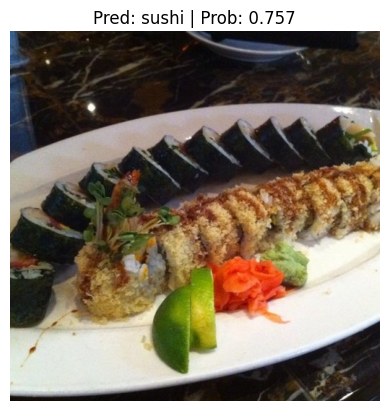

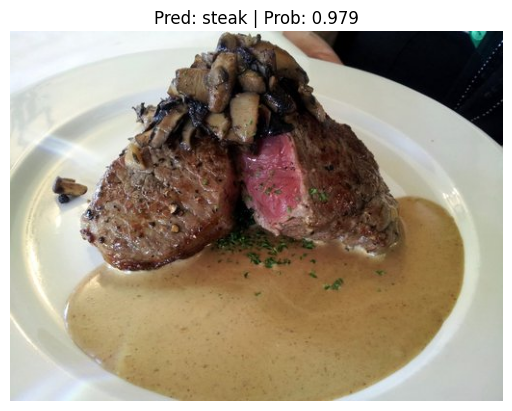

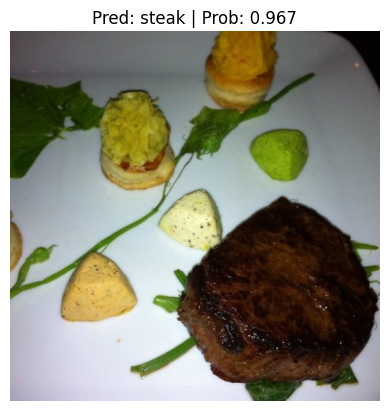

In [87]:
# Import function to make prediction on image and plot them
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / 'test').glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        class_names=class_names,
                        image_path=image_path,
                        image_size=(224, 224))

### 9.1 Predict on a custom image with best model

In [88]:
from pathlib import Path


# Setup custom image path
custom_image_path = Path('data/04-pizza-dad.jpg')

# Download the image if its not exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # Download image from GitHub
        request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
        print(f'Downloading {custom_image_path}')
        f.write(request.content)
else:
    print(f'{custom_image_path} already exist, skipping download.')

data\04-pizza-dad.jpg already exist, skipping download.


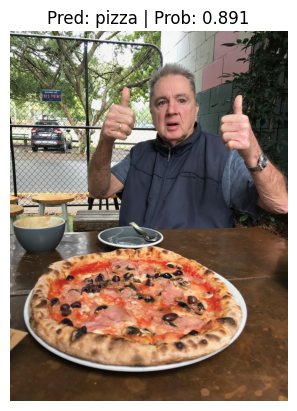

In [89]:
# Predict on our own custom image
pred_and_plot_image(model=best_model,
                    class_names=class_names,
                    image_path=custom_image_path)